In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import torchvision.transforms as transforms

In [ ]:
# for dirname, _, filenames in os.walk('C:\Kaggle'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
image_resolution = 64

In [3]:
transform = transforms.Compose([
    transforms.Resize((image_resolution, image_resolution)),
    transforms.ToTensor()
])

In [4]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

train_data = torchvision.datasets.ImageFolder(root='C:/Kaggle/Dogs vs. Cats/dogs-vs-cats/train',  transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

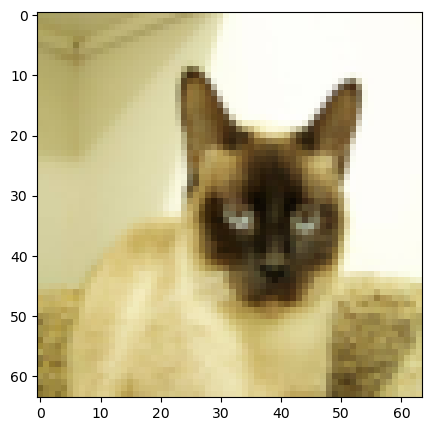

In [5]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()


# get one image from the batch
img = np.squeeze(images[0])

img=img.transpose(1, 2, 0)

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [6]:
class ClassifyEncoder(nn.Module):
    def __init__(self, encoding_dim):
        super(ClassifyEncoder, self).__init__()
        ## encoder ##
        self.layer1 = nn.Linear(3*image_resolution*image_resolution, 128)
        self.layer2 = nn.Linear(128, encoding_dim)

        ## decoder ##
        self.olayer1 = nn.Linear(encoding_dim, 2)

 

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = torch.sigmoid(self.olayer1(x))
    
        return x

encoding_dim = 64
device = "cuda"
model = ClassifyEncoder(encoding_dim).to(torch.device(device))
print(model)

ClassifyEncoder(
  (layer1): Linear(in_features=12288, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (olayer1): Linear(in_features=64, out_features=2, bias=True)
)


In [7]:
# specify loss function
criterion = nn.MSELoss()

# specify optimizer function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
def get_pred_out(labels):
    rv = []
    for x in labels:
        if x == 0:
            y = [1, 0]
        elif x == 1:
            y = [0, 1]
        rv.append(y)
    return torch.Tensor(rv)

In [60]:
# number of epochs to train the model
n_epochs = 5

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, labels = data
        #send to gpu
        images, labels = images.cuda(), labels.cuda()
        # flatten images
        images = images.view(images.size(0), -1)
        #get predicted output
        pred_out = get_pred_out(labels)
        pred_out = pred_out.to(torch.device(device))
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
#         print(outputs.size())
#         print(pred_out.size())
#         print(outputs)
#         print(pred_out)
#         break
        # calculate the loss
        loss = criterion(outputs, pred_out)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 2.924988
Epoch: 2 	Training Loss: 2.895112
Epoch: 3 	Training Loss: 2.854744
Epoch: 4 	Training Loss: 2.854062
Epoch: 5 	Training Loss: 2.843042


tensor([0.8781, 0.1219], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.7601, 0.2399], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.8304, 0.1696], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.9531, 0.0469], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.1422, 0.8578], device='cuda:0', grad_fn=<SelectBackward0>)


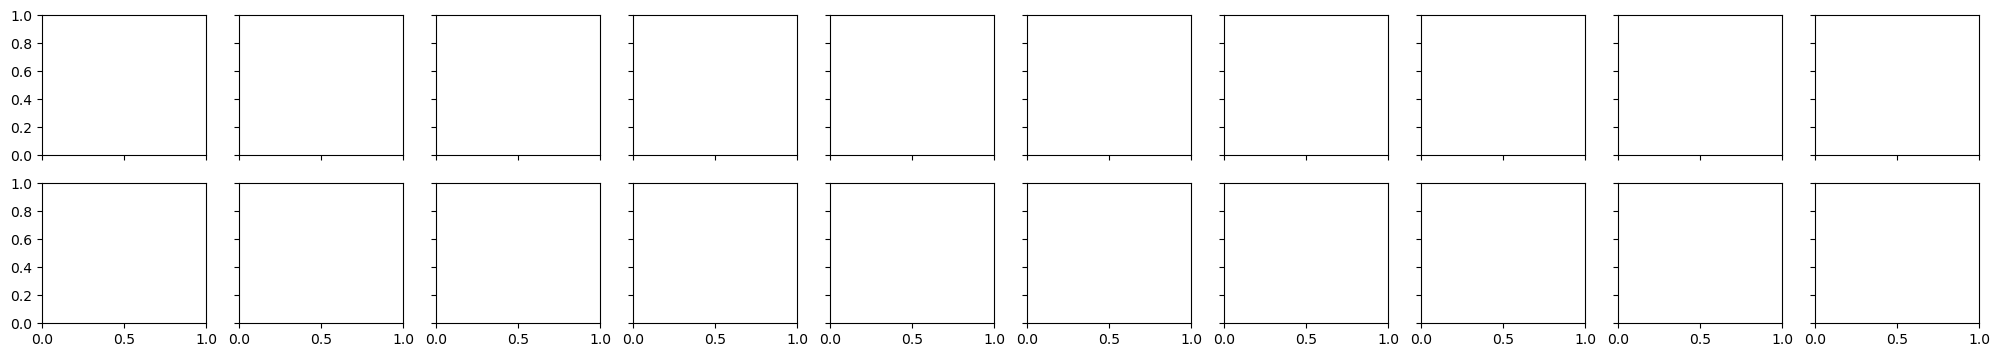

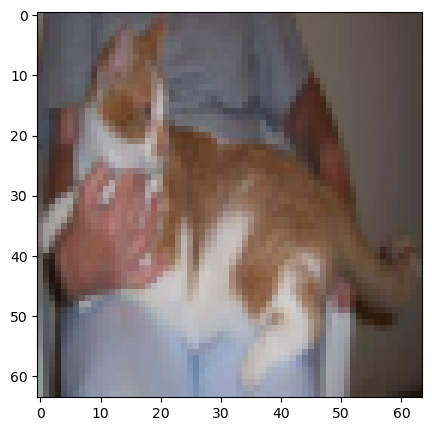

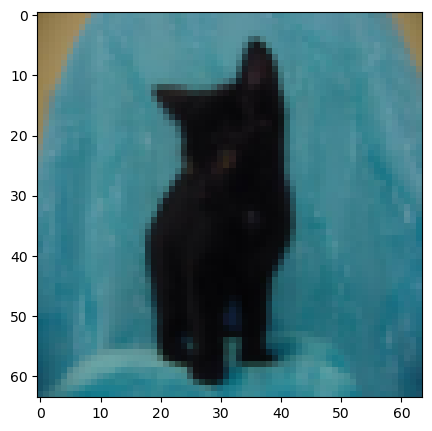

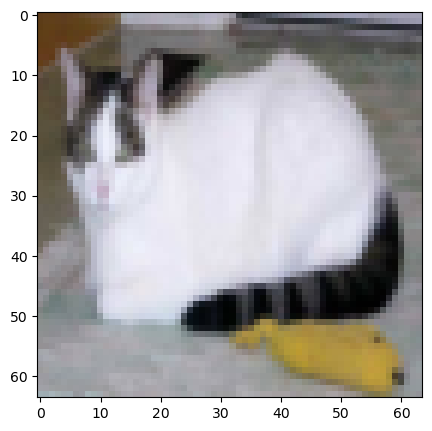

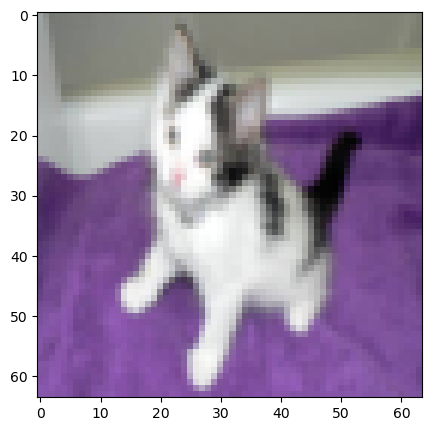

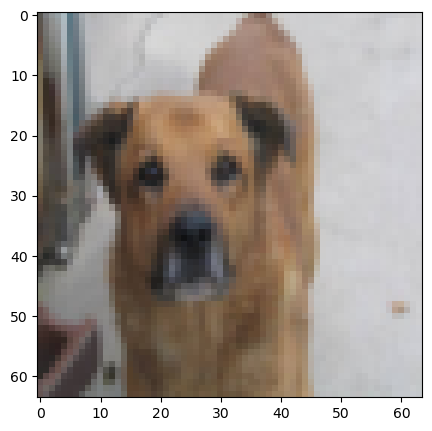

In [74]:
# print(outputs)
# obtain one batch of test images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# print(labels)
images_flatten = images.view(images.size(0), -1).to(torch.device(device))
# get sample outputs
output = model(images_flatten)
# prep images for display
images = images.numpy()
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
#print(output)
for i in range(0, 5):
    img = np.squeeze(images[i])
    img=img.transpose(1, 2, 0)
    fig = plt.figure(figsize = (5,5)) 
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')
    print(output[i]) 

In [76]:
torch.save(model.state_dict(), "C:/Kaggle/DogsVsCats/model/test1.model")